In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from func_file_Model import *
from func_file_Localization import *

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Load model and sample data

In [3]:
model = Load_CNN_model("Model/CNN_model.h5")
samples = np.load("Data/Sample_2.npy")

sample_on = samples[0]
sample_off = samples[1]

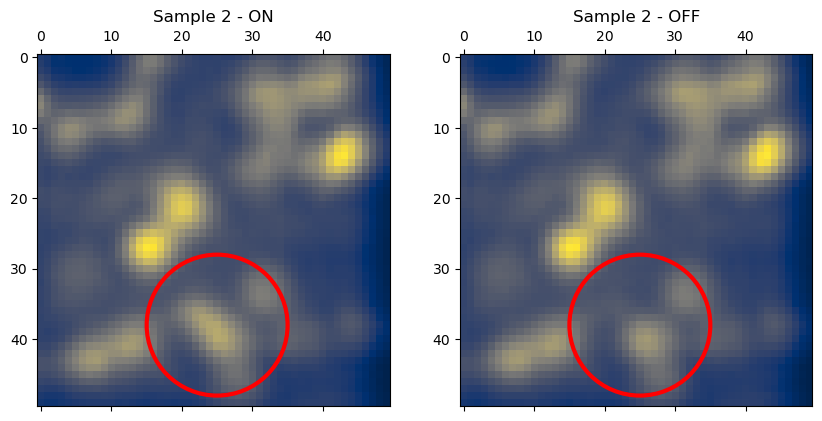

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(sample_on, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25,38], 10, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 2 - ON")

plt.subplot(122)
plt.matshow(sample_off, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25,38], 10, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 2 - OFF")

plt.show()

### Blinking dot localization

In [5]:
#Restriction for np.max search, fit is done within this restriction
restriction_loc = (0, 50, 0, 50)  #0:50 as none is needed for Sample 2

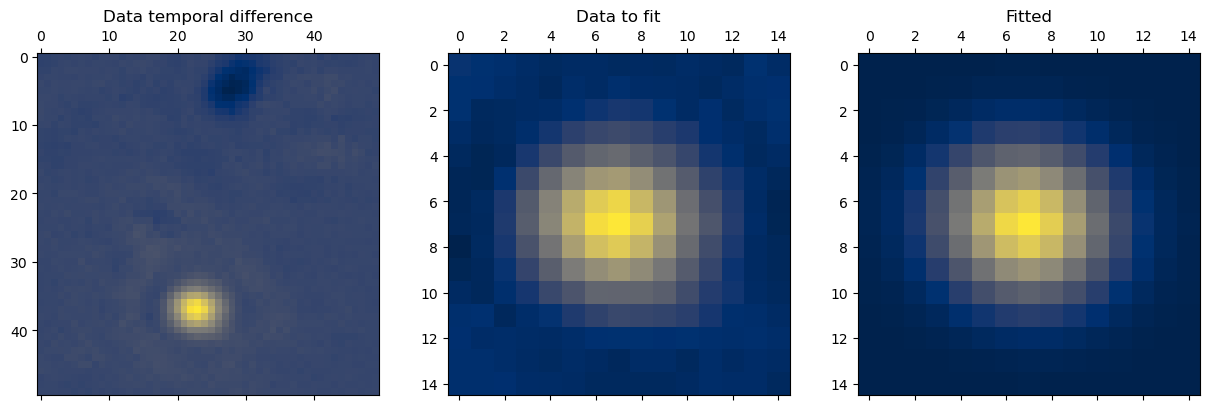

In [6]:
#Localize the dots in the image
all_loc_parameters, all_loc_stds = np.array(Find_center(sample_on - sample_off, restriction_loc, fit_size=7, plot=True, return_all_params=True))
positions_loc = all_loc_parameters[0:2]
stds_loc = all_loc_stds[0:2]
sigmas_loc = all_loc_parameters[3:5]

In [7]:
#Rescale the positions from 50x50 measured grid to 200x200 CNN-recondstructed grid
positions_loc_adjusted = positions_loc * 200/50 + 1.5
stds_loc_adjusted = stds_loc * 200/50

In [8]:
print("Dot position in 50x50: (" + 
      str(np.round(positions_loc[0],3)) + "+-" + str(np.round(stds_loc[0],3)) + ", " + 
      str(np.round(positions_loc[1],3)) + "+-" + str(np.round(stds_loc[1],3)) + ")")

print("")

print("Dot position in 200x200: (" + 
      str(np.round(positions_loc_adjusted[0],3)) + "+-" + str(np.round(stds_loc_adjusted[0],3)) + ", " + 
      str(np.round(positions_loc_adjusted[1],3)) + "+-" + str(np.round(stds_loc_adjusted[1],3)) + ")")

Dot position in 50x50: (36.951+-0.017, 22.863+-0.019)

Dot position in 200x200: (149.303+-0.068, 92.953+-0.077)


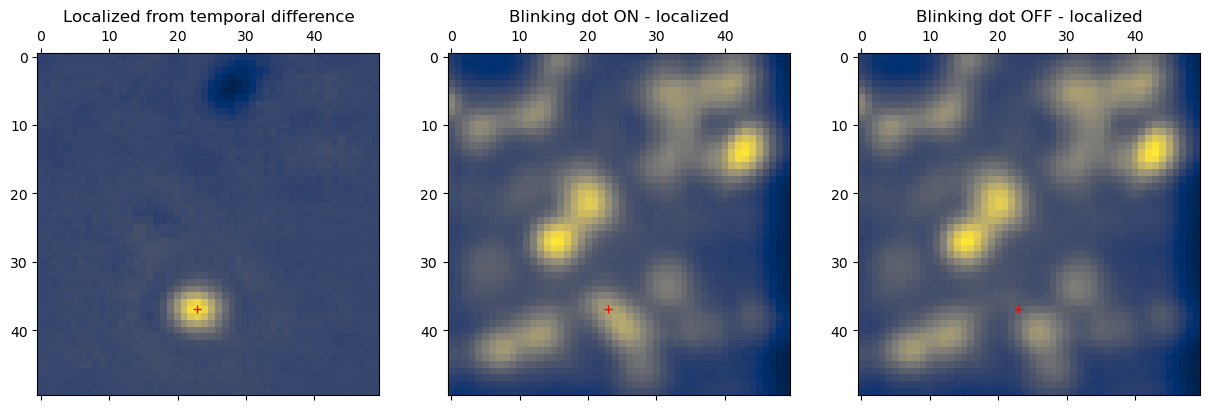

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.matshow(sample_on - sample_off, cmap="cividis", fignum=False)
plt.plot(positions_loc[1], positions_loc[0], '+', color="red")
plt.title("Localized from temporal difference")

plt.subplot(132)
plt.matshow(sample_on, cmap="cividis", fignum=False)
plt.plot(positions_loc[1], positions_loc[0], '+', color="red")
plt.title("Blinking dot ON - localized")

plt.subplot(133)
plt.matshow(sample_off, cmap="cividis", fignum=False)
plt.plot(positions_loc[1], positions_loc[0], '+', color="red")
plt.title("Blinking dot OFF - localized")

plt.show()

### CNN reconstruction

In [10]:
reconstructed = CNN_predict(model, samples)

reconstructed_on = reconstructed[0]
reconstructed_off = reconstructed[1]

1/1 [==============================] - 2s 2s/step


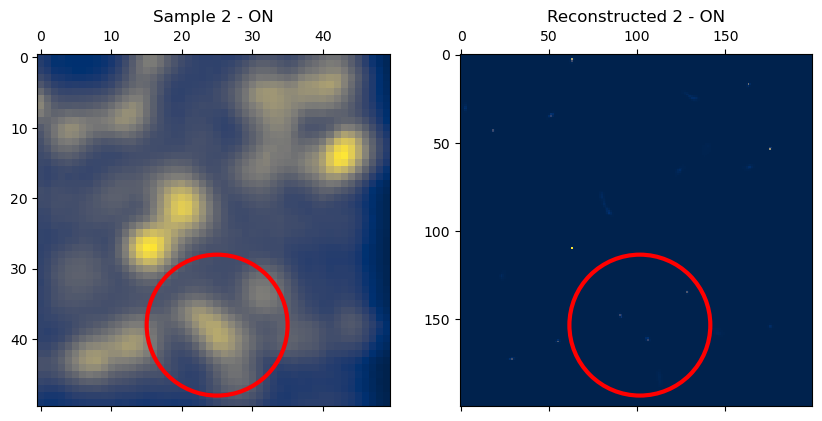

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(sample_on, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25,38], 10, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 2 - ON")

plt.subplot(122)
plt.matshow(reconstructed_on, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25*200/50+1.5, 38*200/50+1.5], 40, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Reconstructed 2 - ON")

plt.show()

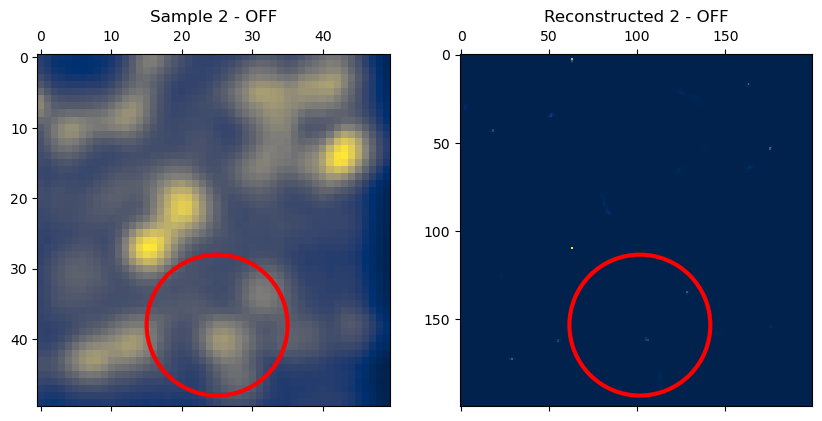

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(sample_off, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25,38], 10, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 2 - OFF")

plt.subplot(122)
plt.matshow(reconstructed_off, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Circle([25*200/50+1.5, 38*200/50+1.5], 40, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Reconstructed 2 - OFF")

plt.show()

### Vizualize

In [13]:
positions_of_max = [
    np.unravel_index(np.argmax(reconstructed_on[130:150,80:100]), [20,20]) + np.array([130,80]), 
    np.unravel_index(np.argmax(reconstructed_on[150:170,100:120]), [20,20]) + np.array([150,100])
]
positions_of_max

[array([148,  90]), array([162, 106])]

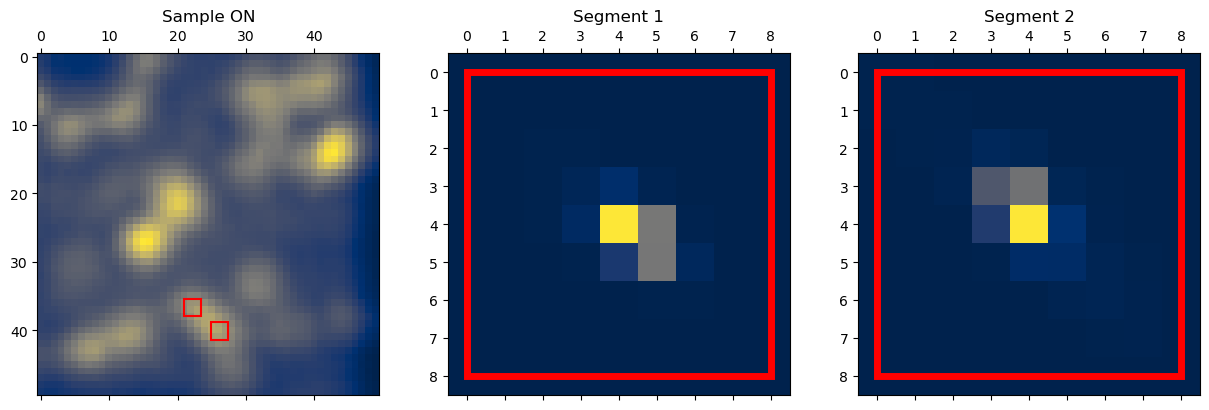

In [14]:
halfsize = 4
std_multi = 3 #uncertainity, multiples of sigma for red circles

REC_center_of_mass_array = np.zeros([2,2])
LOC_center_of_mass_array = np.zeros([1,2])

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.matshow(sample_on, cmap="cividis", fignum=False)
for i in range(len(positions_of_max)):
    x,y = positions_of_max[i]
    x = (x-1.5)/4
    y = (y-1.5)/4
    plt.gca().add_patch(mpl.patches.Rectangle([y-5/4,x-5/4], 10/4, 10/4, linewidth=1.5, edgecolor='red', facecolor='none'))
plt.title("Sample ON")

for i in range(len(positions_of_max)):
    plt.subplot(1,3,i+2)
    x,y = positions_of_max[i]
    
    plt.matshow(reconstructed_on[x-halfsize:x+halfsize+1, y-halfsize:y+halfsize+1], cmap="cividis", fignum=False)
    
    com_x, com_y = scipy.ndimage.center_of_mass(reconstructed_on[x-halfsize:x+halfsize+1, y-halfsize:y+halfsize+1])
    REC_center_of_mass_array[i] = (com_x, com_y)
    
    plt.gca().add_patch(mpl.patches.Rectangle([0,0], 2*halfsize, 2*halfsize, linewidth=5, edgecolor='red', facecolor='none'))
    
    if i == 0:
        LOC_center_of_mass_array[i] = [positions_loc_adjusted[0] - (x - halfsize), positions_loc_adjusted[1] - (y - halfsize)]
    
    plt.title("Segment " + str(i+1))

plt.show()

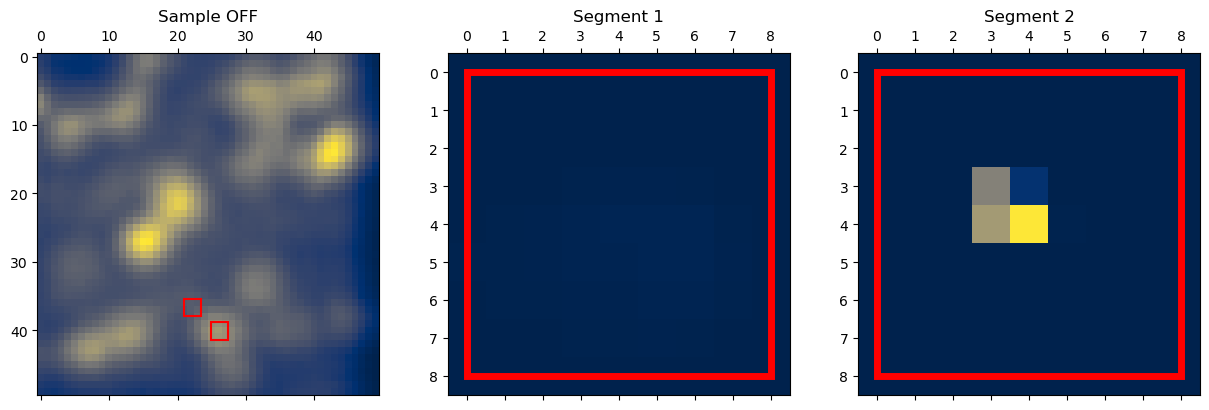

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.matshow(sample_off, cmap="cividis", fignum=False)
for i in range(len(positions_of_max)):
    x,y = positions_of_max[i]
    x = (x-1.5)/4
    y = (y-1.5)/4
    plt.gca().add_patch(mpl.patches.Rectangle([y-5/4,x-5/4], 10/4, 10/4, linewidth=1.5, edgecolor='red', facecolor='none'))
plt.title("Sample OFF")

for i in range(len(positions_of_max)):
    plt.subplot(1,3,i+2)
    x,y = positions_of_max[i]
    
    vmax = np.max(reconstructed_off[positions_of_max[1][0]-halfsize:positions_of_max[1][0]+halfsize+1, positions_of_max[1][1]-halfsize:positions_of_max[1][1]+halfsize+1])
    plt.matshow(reconstructed_off[x-halfsize:x+halfsize+1, y-halfsize:y+halfsize+1], cmap="cividis", vmax=vmax, fignum=False)
    
    plt.gca().add_patch(mpl.patches.Rectangle([0,0], 2*halfsize, 2*halfsize, linewidth=5, edgecolor='red', facecolor='none'))
    
    plt.title("Segment " + str(i+1))

plt.show()

### Estimate resolution variables

In [16]:
#Turn the sigma_x and sigma_y into single sigma_xy for each dot
sigma_xy = np.sqrt(np.mean(sigmas_loc**2))    #sqrt( (x**2 + y**2) / 2 )

#Get Rayleigh resolution limit; defined as first dark ring in the Airy disc
rayleigh_resolution_limit_in_50px = Gaussian_sigma_to_Airy_min(sigma_xy)
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_50px,4), "px of the 50x50 grid.")

#Rescale to um
px_to_camera_um_in_50px = 20
rayleigh_resolution_limit_in_camera_um = rayleigh_resolution_limit_in_50px * px_to_camera_um_in_50px
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_camera_um,4), "um in the camera plane.")

Estimated Rayleigh limit is app. 6.316 px of the 50x50 grid.
Estimated Rayleigh limit is app. 126.3193 um in the camera plane.


In [17]:
#Calculate the Rayleigh limit using imaging setup parameters
wavelength = 932 #nm
NA = 0.7

rayleigh_resolution_limit_in_sample_um = (0.61 * wavelength / NA) / 1000
print("Calculated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_sample_um,4), "um in the sample plane.")

Calculated Rayleigh limit is app. 0.8122 um in the sample plane.


In [18]:
#Estimate the magnification of the imaging setup
magnification = rayleigh_resolution_limit_in_camera_um / rayleigh_resolution_limit_in_sample_um
print("Estimated magnification of the imaging setup is app.", np.round(magnification, 2))

Estimated magnification of the imaging setup is app. 155.53


In [19]:
#Calculate the distance between the reconstruction center of mass and localization position
distance_in_200px = np.linalg.norm(REC_center_of_mass_array[0] - LOC_center_of_mass_array[0])
print("Distance is app.", np.round(distance_in_200px,4), "px of the 200x200 grid.")

distance_in_50px = distance_in_200px / 4
print("Distance is app.", np.round(distance_in_50px,4), "px of the 50x50 grid.")

distance_in_camera_um = distance_in_50px * px_to_camera_um_in_50px
print("Distance is app.", np.round(distance_in_camera_um,4), "um in the camera plane.")

distance_in_sample_um = distance_in_camera_um / magnification
print("Distance is app.", np.round(distance_in_sample_um,4), "um in the sample plane.")
print("Which is app.", np.round(rayleigh_resolution_limit_in_sample_um/distance_in_sample_um,4), "times below the Rayleigh limit.")

Distance is app. 2.774 px of the 200x200 grid.
Distance is app. 0.6935 px of the 50x50 grid.
Distance is app. 13.8699 um in the camera plane.
Distance is app. 0.0892 um in the sample plane.
Which is app. 9.1074 times below the Rayleigh limit.
